
## 1. 项目介绍
> 来自Kaggle的数据集包含了泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。分析有哪些因素会让船上的人生还率更高？

> 1. 女性的生还率会比较高
2. 儿童的生还率会比较高
3. 乘员级别高的生还率会比较高

## 2. 数据清理

In [42]:
import pandas as pd
import numpy as np


# 读取csv文件
filename = 'titanic_data.csv'
df = pd.read_csv(filename)

# 清理数据
def format_df(df):
    # 处理缺失的年龄值
    df['Age'] = df['Age'].fillna(0)
    # 转换年龄为浮点型
    df['Age'] = df['Age'].apply(float)
    return df


df = format_df(df)


def append_age_sex_column(c):
    if c['Age'] > 18:
        if c['Sex'] == 'male':
            return 'Man'
        elif c['Sex'] == 'female':
            return 'Woman'
        else:
            return np.NaN
    elif 0 < c['Age'] <= 18:
        return 'Child'
    else:
        return np.NaN
    
# 增加age_sex列（小于等于18岁的青少年为"Child"，大于18岁男子为"Man"，
# 大于18岁女子为"Woman")
df['Age_Sex'] = df.apply(append_age_sex_column, axis=1)

def calc_survival_ratio(df, key, *value):
    if key == "age":       
        series = df[(df.Age > value[0])
                   & (df.Age <= value[1])]['Survived']
    elif key == "sex":
        series = df[df.Sex == value[0]]['Survived']
    elif key == "level":
        series = df[df.Pclass == value[0]]['Survived']
    elif key == "age_sex":
        series = df[df.Age_Sex == value[0]]['Survived']
    elif key == "age_sex_level":
        series = df[(df.Age_Sex == value[0])
                    & (df.Pclass == value[1])]['Survived']
        
    saved_ratio = series.sum() / (series.shape[0] * 1.0)
    return saved_ratio

# def calc_survival_ratio(df, age, sex, level, age_sex):  
#       # 性别+年龄+乘员级别
#       if age_group and level:
#           if age_group == 'child':
#               series = df[(df.Age <= 18)
#                           & (df.Pclass == level) ]['Survived']
#           elif age_group in ('male', 'female'):
#               series = df[(df.Sex == age_group)
#                           & (df.Age > 18)
#                           & (df.Pclass == level)]['Survived']           
#       # 性别+年龄
#       elif age_group:
#           if age_group == 'child':
#               series = df[df.Age <= 18]['Survived']
#           elif age_group in ('male', 'female'):
#               series = df[(df.Sex == age_group)
#                           & (df.Age > 18)]['Survived']
#       # 乘员级别
#       else:
#           series = df[df.Pclass == level]['Survived']

#       saved_ratio = series.sum() / (series.shape[0] * 1.0)
#       return saved_ratio

df.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Man
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Woman
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Woman
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Woman
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Man
5,6,0,3,"Moran, Mr. James",male,0.0,0,0,330877,8.4583,NaN,Q,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Man
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Child
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Woman
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Child


## 3. 分析数据
### 3.1. 按年龄组进行分析
#### 分组方式
>
小于等于18岁的一组，大于18岁为一组

#### 结论
> 
'从柱状图可以看出，儿童的生还率>成人的生还率

In [44]:
age_group_saved_df = pd.DataFrame(
    data={'Saved ratio': [calc_survival_ratio(df, "age", 0, 18), 
                          calc_survival_ratio(df, "age", 18, 100)]},
    index=['child', 'adult']
)


%pylab inline
import matplotlib.pyplot as plt

age_group_saved_df.index = [
    'child', 'adult'
]
age_group_saved_df.plot(kind='bar')

SyntaxError: EOL while scanning string literal (<ipython-input-44-82d271f522e3>, line 3)

### 3.2. 按性别组进行分析
#### 分组方式
>
男性为一组，女性为一组

#### 结论
> 从柱状图可以看出，女性的生还率>男性的生还率

Populating the interactive namespace from numpy and matplotlib


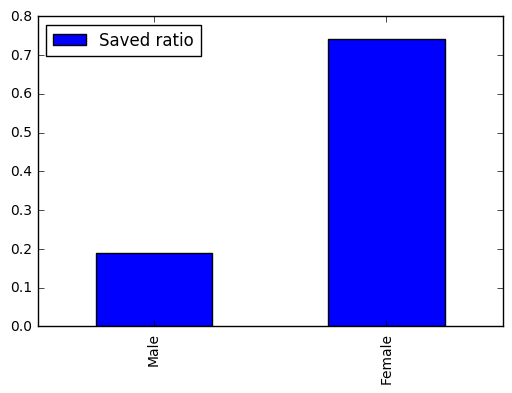

In [45]:

  
age_group_saved_df = pd.DataFrame(
    data={'Saved ratio': [calc_survival_ratio(df, "sex", "male"), 
                          calc_survival_ratio(df, "sex", "female")]},
    index=['Male', 'Female']
)


%pylab inline
import matplotlib.pyplot as plt

age_group_saved_df.index = [
    'Male', 'Female'
]
age_group_saved_df.plot(kind='bar')

### 3.3. 按乘员级别组进行分析
#### 分组方式
>
class1为一组，class2为一组，class3为一组

#### 结论
> 从柱状图可以看出，class1 > class2 > class3

136 216
87 184
119 491
Populating the interactive namespace from numpy and matplotlib


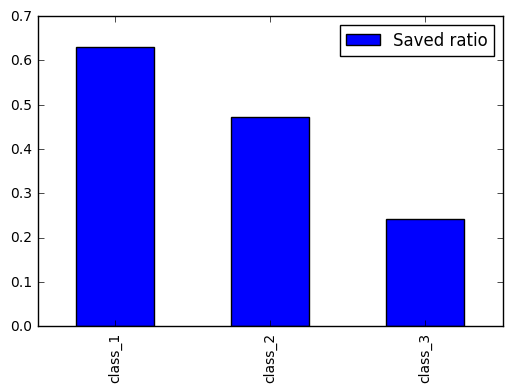

In [11]:
class_group_saved_df = pd.DataFrame(
    data={'Saved ratio': [get_age_class_ratio(df, None, 1), get_age_class_ratio(df, None, 2), get_age_class_ratio(df, None, 3)]},
    index=['class 1', 'class 2', 'class 3']
)

%pylab inline
import matplotlib.pyplot as plt

class_group_saved_df.index = [
    'class_1', 'class_2', 'class_3'
]
class_group_saved_df.plot(kind='bar')

### 3.3. 按乘员和乘员级别组进行分析
#### 分组方式
>
青少年按class分三组，成年男子按class分三组，成年女子按class分三组

#### 结论
> 从柱状图可以看出，除了成年男子中class3大约class2，其他乘员级别内都按class顺序排列；成年女子略高于青少年，成年男子最低

14 16
23 29
33 94
36 96
6 84
27 202
72 74
54 60
25 59
Populating the interactive namespace from numpy and matplotlib


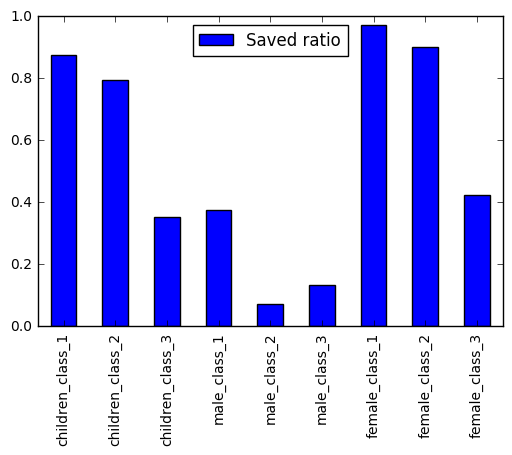

In [12]:
index_arrays = [np.array(['Children']*3 + ['Men']*3 + ['Women']*3),
               np.array(['class 1', 'class 2', 'class 3']*3)]
age_class_group_saved_df = pd.DataFrame(
    data={'Saved ratio': [get_age_class_ratio('child', 1), 
                          get_age_class_ratio('child', 2), 
                          get_age_class_ratio('child', 3),
                          get_age_class_ratio('male', 1), 
                          get_age_class_ratio('male', 2), 
                          get_age_class_ratio('male', 3),
                          get_age_class_ratio('female', 1), 
                          get_age_class_ratio('female', 2), 
                          get_age_class_ratio('female', 3)
                         ]},
    index=index_arrays
)


%pylab inline
import matplotlib.pyplot as plt

age_class_group_saved_df.index = [
    'children_class_1', 'children_class_2', 'children_class_3',
    'male_class_1', 'male_class_2', 'male_class_3',
    'female_class_1', 'female_class_2', 'female_class_3'
]
age_class_group_saved_df.plot(kind='bar')